# Setup

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sys

from deap import algorithms, base, creator, tools

from sympy import *

from scipy.stats import spearmanr

sys.path.append('../promoter_solving/')
from promoter_solving_core import *

In [4]:
# Load csv with mRNA_ratio, MA_act, MA_inh
data = pd.read_csv('../data/pickle_dfs/zerod_M_MA_for_activator_inhibitor_and_mRNA_ratios_df.csv', index_col=0)
data.head()

,MA_activator,MA_inhibitor,actual_mRNA_ratio
control__wt_glc__1,0.019182,0.028499,2.186692
control__wt_glc__2,-0.019182,-0.028499,2.369230
fur__wt_dpd__1,-0.963901,-0.473642,0.490542
fur__wt_dpd__2,-1.116929,-0.541595,0.492320
fur__wt_fe__1,0.043720,-0.054857,1.756930


# Create Grids for Each Condition

In [5]:
grid = pd.DataFrame(columns = ['mRNA_ratio','grid'], index = data.index)
grid.loc[:,'mRNA_ratio'] = data.loc[:,'actual_mRNA_ratio']

In [6]:
equation = sympify('Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
KeqOpening)*RNAP))')
equation

Eq(mRNARatio, (KdRNAP*cActivator + KdRNAPCrp)*(KdRNAP + KeqOpening*RNAP + RNAP)/(KdRNAP*KdRNAPCrp*(cActivator + cInhibitor + 1) + KdRNAP*RNAP*cActivator*(KeqOpening + 1) + KdRNAPCrp*RNAP*(KeqOpening + 1)))

In [7]:
# Define constants
constant_vals = {
    # NOTE: MAKE SURE TO UPDATE IF ANYTHING IS CHANGED
    'KdRNAP': 10**-5,
    'KdRNAPCrp': 2.5118864315095796e-07*1.4,
    'KeqOpening': 10**-0.34444956947383365,
    'RNAP': 10**-6, 
}

In [495]:
# Create lambda functions that we can plug in to
lambda_df = create_lambdas(equation, constant_vals)

# Parameter we are solving for using the other two
solve = 'cInhibitor' # Solve for this by setting the other (e.g. solve = cInhibitor if cActivator is known)

input_range = {
    'cActivator': [0,10],
    #'cInhibitor': [0,50],
}

for i, condition in enumerate(grid.index):
    # Create a working grid based on cActivator, we will add cInhibitor values 
    # to it to ensure they always result in mRNA ratio
    working_grid = create_parameter_grid(num_steps = 101, **input_range)

    # Use a dict just in case order of tuple to sub into lambda function ever changes
    values = {'mRNARatio': grid.loc[condition,'mRNA_ratio']}
    for ii, pair in enumerate(working_grid):
        values[list(input_range.keys())[0]] = pair[0] #NOTE: May break if we try to run both at same time
        
        # Create a tuple in the correct order to pass into the lambda function
        values_tuple = tuple([values[p] for p in lambda_df.loc[solve,'order']])
    
        # Evaluate the lambda function, order is currently (cActivator, cInhibitor)
        working_grid[ii] += ((lambda_df.loc[solve,'lambda'](values_tuple))[0],)
    
    # Save to grid df
    grid.at[condition, 'grid'] = working_grid

In [472]:
# Create a combined grid
# Create lambda functions that we can plug in to
lambda_df = create_lambdas(equation, constant_vals)

cAct_range = {'cActivator': [0,10]}
cInh_range = {'cInhibitor': [0,4]} # Use a log10 range and convert back after creating grid

for i, condition in enumerate(grid.index):
    # Create a working grid based on cActivator, we will add cInhibitor values 
    # to it to ensure they always result in mRNA ratio
    cAct_grid = create_parameter_grid(num_steps = 51, **cAct_range)
    cInh_grid = create_parameter_grid(num_steps = 51, **cInh_range)
    cInh_grid = [[10**x[0]] for x in cInh_grid]

    # Use a dict just in case order of tuple to sub into lambda function ever changes
    values = {'mRNARatio': grid.loc[condition,'mRNA_ratio']}
    for ii, pair in enumerate(cAct_grid):
        values['cActivator'] = pair[0] # Add cAct to values dict
        
        # Create a tuple in the correct order to pass into the lambda function
        values_tuple = tuple([values[p] for p in lambda_df.loc['cInhibitor','order']])
    
        # Evaluate the lambda function, order is currently (cActivator, cInhibitor)
        cAct_grid[ii] += ((lambda_df.loc['cInhibitor','lambda'](values_tuple))[0],)

    values = {'mRNARatio': grid.loc[condition,'mRNA_ratio']}
    for ii, pair in enumerate(cInh_grid):
        values['cInhibitor'] = pair[0] # Add cInh to values dict
        
        # Create a tuple in the correct order to pass into the lambda function
        values_tuple = tuple([values[p] for p in lambda_df.loc['cActivator','order']])
    
        # Evaluate the lambda function, order is currently (cActivator, cInhibitor)
        cInh_grid[ii] = ((lambda_df.loc['cActivator','lambda'](values_tuple))[0],cInh_grid[ii][0]) # Need to reverse the tuples to maintain (cAct, cInh) order when combining the two grids
    
    working_grid = sorted(cAct_grid + cInh_grid)
    
    # Save to grid df
    grid.at[condition, 'grid'] = working_grid

In [366]:
grid.head()

,mRNA_ratio,grid
control__wt_glc__1,2.186692,"[(0.0, -0.6215098252031866), (0.16609010284913..."
control__wt_glc__2,2.369230,"[(0.0, -0.6618609214775106), (0.19289423989613..."
fur__wt_dpd__1,0.490542,"[(-0.0030919092063949683, 1.0), (0.0, 1.189405..."
fur__wt_dpd__2,0.492320,"[(-0.0029658404950030203, 1.0), (0.0, 1.180971..."
fur__wt_fe__1,1.756930,"[(0.0, -0.49339972486388645), (0.1113995216896..."


# DEAP

In [497]:
creator.create(name = 'fitness',
               base = base.Fitness,
               weights = (1.0, -1.0,)) # Set to maximize Spearman correlation of MA_activator and cActivator, and minimize MA_inhibitor and cInhibitor

creator.create(name = 'individual',
               base = np.ndarray,
               fitness = creator.fitness)

toolbox = base.Toolbox()

random.seed(42)

def generate_individual(individual_class: type, data: pd.DataFrame):
    individual = individual_class(random.sample(grid,1)[0] for grid in grid['grid'])
    
    return individual

toolbox.register(alias = 'individual',
                 function = generate_individual,
                 individual_class = creator.individual,
                 data = grid)

toolbox.register('population',
                 tools.initRepeat,
                 list,
                 toolbox.individual)

In [498]:
test_population = toolbox.population(n=3)

In [499]:
# Evaluate
MA_df = data.iloc[:,0:2]

def spearman_objective(individual: object, MA_df: pd.DataFrame):
    """
    Calculate spearman coefficient between cAct/cInh and MA_act/MA_inh
    :param object individual: DEAP individual
    :param pd.DataFrame MA_df: Df with columns = ['MA_activator','MA_inhibitor']
    """

    MA_activator = MA_df.loc[:,'MA_activator']
    MA_inhibitor = MA_df.loc[:,'MA_inhibitor']
    
    # NOTE: Need to swap 0 and 1 depending if calculating using cInhibitor or cActivator
    # NOTE: This is hardcoded and may break depending on if we try to run the two simultaneously
    if solve == 'cInhibitor':
        ind_activator = individual[:,0]
        ind_inhibitor = individual[:,1]
    else:
        ind_activator = individual[:,1]
        ind_inhibitor = individual[:,0]
    
    activator_spearman = spearmanr(MA_activator, ind_activator)[0]
    inhibitor_spearman = spearmanr(MA_inhibitor, ind_inhibitor)[0]
    
    return activator_spearman, inhibitor_spearman,

toolbox.register(alias = 'evaluate', function = spearman_objective, MA_df = MA_df)

In [500]:
toolbox.evaluate(test_population[0])

(0.04163016706958983, -0.6884556869279006)

In [501]:
toolbox.register("select", tools.selNSGA2, nd='log')

In [502]:
# Mutation
def mutate(individual: object, prob: float, data: pd.DataFrame):
    for i, _ in enumerate(individual):
        if random.random() < prob:
            individual[i] = random.sample(grid.iloc[i,1],1)[0]

    return individual,

mt_prob = 0.1  #NOTE: CHANGE ME
toolbox.register('mutate', function = mutate, prob = mt_prob, data = data)

In [503]:
# Crossover
def crossover(ind_one: object, ind_two: object, prob: float,):

    for i, _ in enumerate(ind_one):
        if random.random() < prob:
            ind_one[i], ind_two[i] = ind_two[i].copy(), ind_one[i].copy()

    return ind_one, ind_two

cx_prob = 0.1 # NOTE: CHANGE ME

toolbox.register(alias = "mate", function = crossover, prob = cx_prob,)

In [504]:
stats = tools.Statistics(lambda ind: ind.fitness.values) # NOTE: update these to actually be useful
stats.register("min", np.min)
stats.register("max", np.max)

In [505]:
def mu_plus_lambda(population = list,
                   toolbox = base.Toolbox(),
                   mu = int,
                   lambda_ = int,
                   cxpb = float,
                   mutpb = float,
                   ngen = int,
                   stats = None,
                   hall_of_fame = None,
                   verbose = __debug__):
    """
    Modified DEAP mu+lambda evolutionary algorithm using varOr

    :param list population: List of individuals to serve as the starting population
    :param base.Toolbox() toolbox: DEAP class containing evolution operators
    :param int mu: Number of individuals to select for the next generation
    :param int lambda_: Number of children to produce at each generation
    :param float cxpb: Probability that an offspring is produced by crossover
    :param float mutpb: Probability that an offspring is produced by mutation
    :param int ngen: Number of generations to run
    :param stats: DEAP class containing the types of statistics to record in the logbook
    :param halloffame: DEAP class containing the best individuals evaluated
    :param verbose: Whether or not to print statistics for each generation
    :returns list pop: Final population
    :returns logbook: DEAP class containing stats for every generation

    evaluate(population)
    for g in range(ngen):
        offspring = varOr(population, toolbox, lamda_, cxpb, mutpb)
        evaluate(offspring)
        gradient_offspring = create_gradient_offspring(hof[0], toolbox)
        evaluate(gradient_offspring)
        population = select(population+offspring+gradient_offspring, mu)
    """

In [506]:
# NOTE: Using np.ndarray individuals requires a different method to compare individuals
nind = 100
mu = 100
lambda_ = 100
cxpb = 0.7
mutpb = 0.3
ngen = 10000

pop, logbook = algorithms.eaMuPlusLambda(toolbox.population(n=nind), toolbox, mu=mu, lambda_=lambda_, # NOTE: Need to use eaMuPlusLambda for elitism to occur
            cxpb=cxpb, mutpb=mutpb, ngen=ngen, stats=stats, verbose=True)

gen	nevals	min      	max     
0  	100   	-0.682414	0.164534
1  	100   	-0.691352	0.177681
2  	100   	-0.700629	0.21434 
3  	100   	-0.702229	0.232541
4  	100   	-0.702229	0.232541
5  	100   	-0.707881	0.248305
6  	100   	-0.707881	0.258629
7  	100   	-0.711633	0.258629
8  	100   	-0.722525	0.258629
9  	100   	-0.722525	0.258629
10 	100   	-0.726594	0.271915
11 	100   	-0.726983	0.304812
12 	100   	-0.733306	0.315976
13 	100   	-0.73646 	0.323291
14 	100   	-0.737058	0.323291
15 	100   	-0.740454	0.327202
16 	100   	-0.750916	0.327202
17 	100   	-0.750916	0.344845
18 	100   	-0.750916	0.344845
19 	100   	-0.750916	0.351578
20 	100   	-0.752966	0.354277
21 	100   	-0.75936 	0.369328
22 	100   	-0.760131	0.369328
23 	100   	-0.7641  	0.381214
24 	100   	-0.7641  	0.415071
25 	100   	-0.777989	0.415071
26 	100   	-0.777989	0.415071
27 	100   	-0.78414 	0.416168
28 	100   	-0.78414 	0.4376  
29 	100   	-0.790182	0.439299
30 	100   	-0.793451	0.439299
31 	100   	-0.796532	0.445094
32 	100   

In [507]:
# Determine best individual
a, b = zip(*[pop[i].fitness.values for i in range(len(pop))])
total_score = np.subtract(a,b)
total_sort = np.argsort(total_score)
best_location = total_sort[-1]
best_individual = pop[best_location]

In [508]:
total_score[total_sort]

array([1.46780752, 1.46822559, 1.47435937, 1.47477745, 1.47954012,
       1.48132261, 1.48620164, 1.48968146, 1.49087059, 1.49639314,
       1.4965519 , 1.5029225 , 1.50842618, 1.51056776, 1.51775262,
       1.51933883, 1.52528028, 1.52528028, 1.5290061 , 1.53093881,
       1.53345972, 1.53690657, 1.53794392, 1.54021585, 1.54532822,
       1.54637557, 1.55239639, 1.55410214, 1.55565129, 1.55677238,
       1.55888876, 1.56175888, 1.56184681, 1.56491757, 1.56659607,
       1.56878008, 1.57091029, 1.57421194, 1.57600017, 1.58137325,
       1.58292588, 1.58655939, 1.5889027 , 1.59123536, 1.5927049 ,
       1.59452977, 1.59632588, 1.59707821, 1.59959514, 1.60202138,
       1.60226125, 1.60321306, 1.60549641, 1.60563731, 1.60653323,
       1.60671145, 1.60730135, 1.60761079, 1.60997938, 1.61050433,
       1.61210113, 1.61233542, 1.61244335, 1.6131805 , 1.61437543,
       1.61515321, 1.61586852, 1.61604301, 1.61613113, 1.61670244,
       1.6171496 , 1.61774543, 1.61774543, 1.61854579, 1.61888

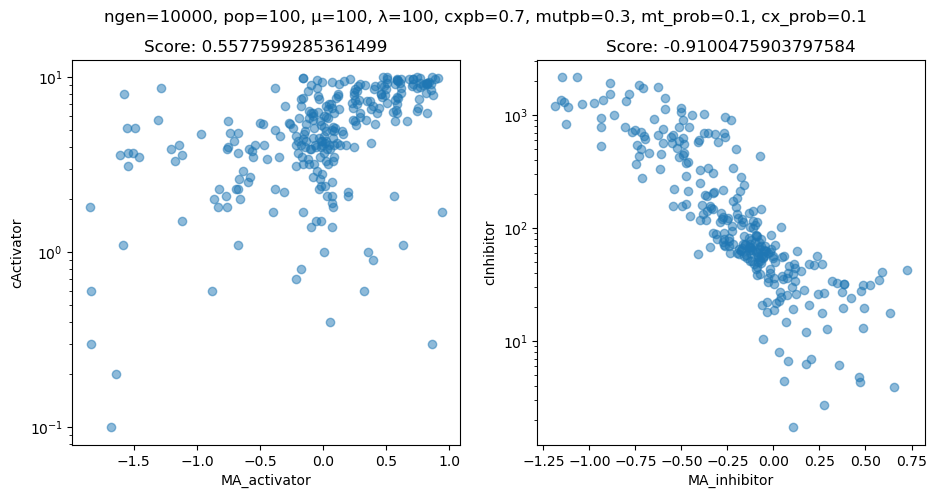

In [509]:
plot_individual = pop[total_sort[0]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11,5), squeeze= True)
title = 'ngen='+str(ngen)+', pop='+str(nind)+', μ='+str(mu)+', λ='+str(lambda_)+', cxpb='+str(cxpb)+', mutpb='+str(mutpb)+', mt_prob='+str(mt_prob)+', cx_prob='+str(cx_prob)
fig.suptitle(title)
ax1.set_xlabel('MA_activator')
ax2.set_xlabel('MA_inhibitor')
ax1.set_ylabel('cActivator')
ax2.set_ylabel('cInhibitor')
ax1.set_yscale('log')
ax2.set_yscale('log')

eval_act, eval_inh = toolbox.evaluate(plot_individual)
ax1.set_title('Score: '+str(eval_act))
ax2.set_title('Score: '+str(eval_inh))

if solve == 'cInhibitor':
    # If cActivator is used to calculate cInhibitor
    ax1.scatter(MA_df.iloc[:,0], plot_individual[:,0], alpha=0.5)
    ax2.scatter(MA_df.iloc[:,1], plot_individual[:,1], alpha=0.5)
else: 
    # If cInhibitor is used to calculate cActivator
    ax1.scatter(MA_df.iloc[:,0], plot_individual[:,1], alpha=0.5)
    ax2.scatter(MA_df.iloc[:,1], plot_individual[:,0], alpha=0.5)

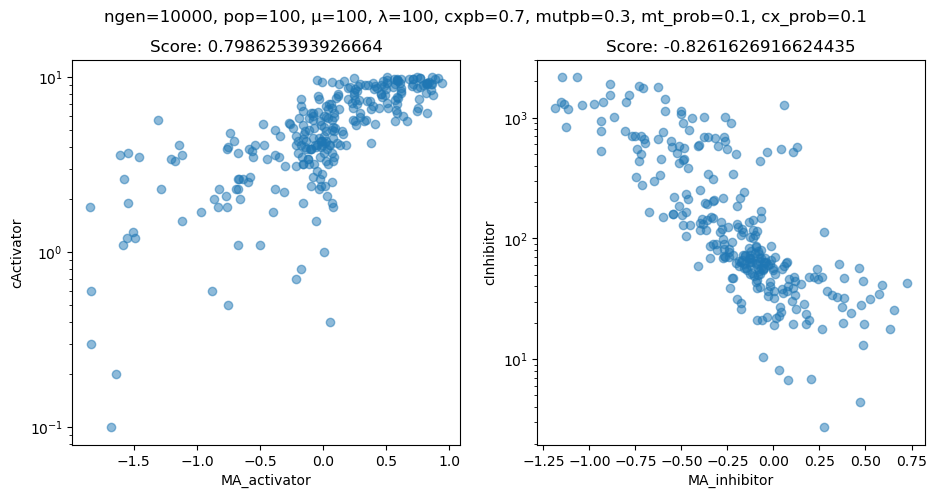

In [510]:
plot_individual = pop[total_sort[-1]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11,5), squeeze= True)
title = 'ngen='+str(ngen)+', pop='+str(nind)+', μ='+str(mu)+', λ='+str(lambda_)+', cxpb='+str(cxpb)+', mutpb='+str(mutpb)+', mt_prob='+str(mt_prob)+', cx_prob='+str(cx_prob)
fig.suptitle(title)
ax1.set_xlabel('MA_activator')
ax2.set_xlabel('MA_inhibitor')
ax1.set_ylabel('cActivator')
ax2.set_ylabel('cInhibitor')
ax1.set_yscale('log')
ax2.set_yscale('log')

eval_act, eval_inh = toolbox.evaluate(plot_individual)
ax1.set_title('Score: '+str(eval_act))
ax2.set_title('Score: '+str(eval_inh))

if solve == 'cInhibitor':
    # If cActivator is used to calculate cInhibitor
    ax1.scatter(MA_df.iloc[:,0], plot_individual[:,0], alpha=0.5)
    ax2.scatter(MA_df.iloc[:,1], plot_individual[:,1], alpha=0.5)
else: 
    # If cInhibitor is used to calculate cActivator
    ax1.scatter(MA_df.iloc[:,0], plot_individual[:,1], alpha=0.5)
    ax2.scatter(MA_df.iloc[:,1], plot_individual[:,0], alpha=0.5)

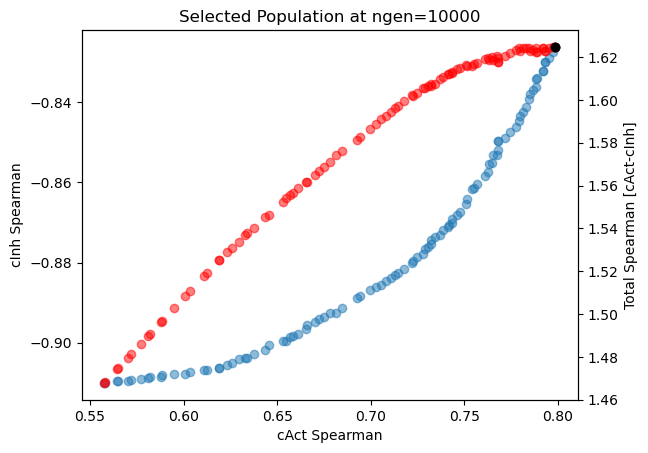

In [511]:
# Plot the final population and their total score
fig, ax1 = plt.subplots()
ax1.scatter(a, b, alpha=0.5)
ax2 = ax1.twinx()
ax2.scatter(a, total_score, alpha=0.5, c='r')
ax1.set_title('Selected Population at ngen='+str(ngen))
ax1.set_xlabel('cAct Spearman')
ax1.set_ylabel('cInh Spearman')
ax2.set_ylabel('Total Spearman [cAct-cInh]')
ax1.scatter(a[best_location], b[best_location], c='k')
ax2.scatter(a[best_location], total_score[best_location], c='k')

Text(0.5, 0, 'Generation')

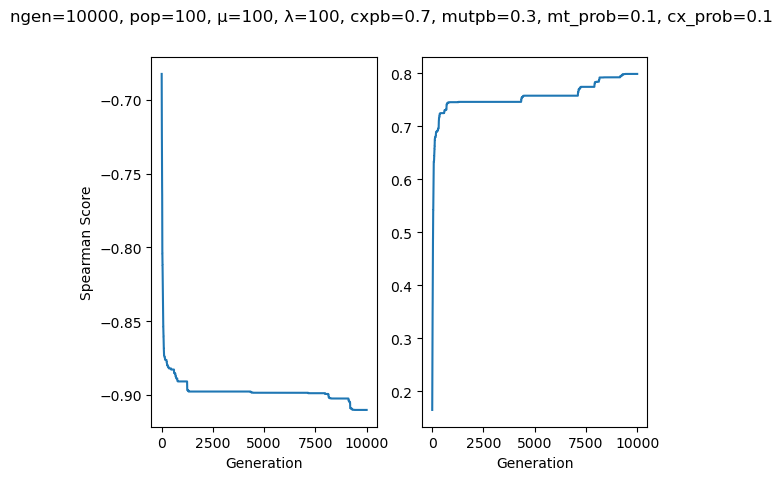

In [512]:
# Plot fitness of best individuals over time and compare to hof
gen = np.linspace(0, ngen, ngen+1)
gen_min = []
gen_max = []

for gen_dict in logbook:
    gen_min.append(gen_dict['min'])
    gen_max.append(gen_dict['max'])

fig, [ax1, ax2] = plt.subplots(1,2)
title = 'ngen='+str(ngen)+', pop='+str(nind)+', μ='+str(mu)+', λ='+str(lambda_)+', cxpb='+str(cxpb)+', mutpb='+str(mutpb)+', mt_prob='+str(mt_prob)+', cx_prob='+str(cx_prob)
fig.suptitle(title)
ax1.plot(gen, gen_min)
ax1.set_xlabel('Generation')
ax1.set_ylabel('Spearman Score')

ax2.plot(gen, gen_max)
ax2.set_xlabel('Generation')

In [271]:
"""
- Implement "gradient offspring" using output to test the method
- NSGA-II works in the objective function space, we want to work in the parameter space
- Partial derivative of the mRNA ratio equation isn't useful because that is not our objective function
- Spearman function is ranked based so it does not have any gradient information
- Goal: While holding parameters from all other conditions the same, evaluate the change in fitness of an individual whose parameters have been modified.
    - Throw these individuals into the population that is selected from to seed the next generation
"""

n_steps = 1
n_conditions = len(hof[0])
temp_fitness = hof[0].fitness
temp_population = toolbox.population(n=0) # Create population class to hold the individuals we are trying out

# Rather than deal with having to look up where the tuple is, I think my next step should be to make the first n tuples correspond to the locations of the n parameters that are set in each tuple
# For this case, that would mean that the first number would correspond to the position of the cAct value in the list

for i, (act, inh) in enumerate(hof[0]): # Iterate over each condition's parameters in the hof individual
    for ii, (grid_act, grid_inh) in enumerate(grid.grid[i]): # Locate the position of the tuple in the grid. I'm worried about rounding errors, so I want to shift to the method described above.
        if (act, inh) == (grid_act, grid_inh):
            position = ii

    # For each condition, evaluate the fitness of changing one condition's parameters at a time.
    temp_individual_plus = creator.individual(hof[0])
    temp_individual_minus = creator.individual(hof[0])
    temp_individual_plus[i] = position+1
    temp_individual_minus[i] = position-1
    temp_individual_plus.fitness.values = toolbox.evaluate(temp_individual_plus)
    temp_individual_minus.fitness.values = toolbox.evaluate(temp_individual_minus)

    # Add them back to the population
    temp_population.append(temp_individual_plus)
    temp_population.append(temp_individual_minus)

In [274]:
temp_population[1].fitness.values

(0.7589069339646894, -0.798985773054942)

In [382]:
temp_selected = toolbox.select(temp_population, k = 2)
temp_selected[0].fitness.values

(0.7729621149988504, -0.7996438013501589)